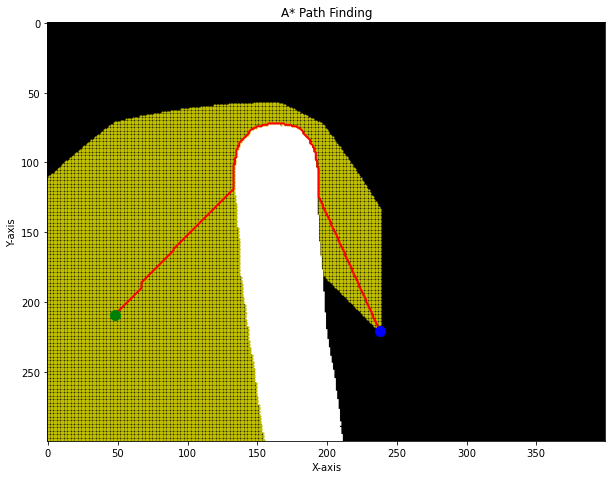

keypoints initialized :  [array([154, 111]), array([222,  91]), array([264, 185]), array([276, 206])]
distance to keypoint:  251.7173817682328
distance to keypoint:  245.96262201492013
distance to keypoint:  233.0492900153425
distance to keypoint:  220.40631862447424
distance to keypoint:  207.61286552720188
distance to keypoint:  193.94331398806327
distance to keypoint:  180.20187688060787
distance to keypoint:  166.46599757219568
distance to keypoint:  154.19408737536548
distance to keypoint:  140.47859388940412
distance to keypoint:  126.77601755283865
distance to keypoint:  113.48890074619372
distance to keypoint:  100.65837452441608
distance to keypoint:  85.80353046961996
distance to keypoint:  72.71689821563083
distance to keypoint:  59.094828483889145
distance to keypoint:  46.30142559997481
distance to keypoint:  33.30783573116388
old keypoints : [array([222,  91]), array([264, 185]), array([276, 206])]
new keypoints : [array([264, 185]), array([276, 206])]
changing goal, new 

In [2]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import cv2
from tdmclient import ClientAsync, aw
from final_camera_class import *
from final_Thymio_class import *
from final_path import *
from motion import *

###########################################################
#Parameters
###########################################################
camera_index=1 #0 if no webcam
corner_aruco_id=[0, 1, 2, 10] #top-left, bottom-left, bottom-right, top-right
corner_aruco_size=65 #mm
min_size=500 #minimum blob size
thresh_obstacle=np.array([[40,20,120,65,50,160]]) #BGR
thresh_goal=np.array([40,40,20,60,150,65]) #BGR
Thymio_id=9
grid_size0=400 #blocks? TBD numbers of blocks or pixels?
grid_size1=300 #blocks? TBD numbers of blocks or pixels?
ANGLE_THRESHOLD = np.radians(40)   #threshold under which changes of directions are ignored [rad]
STEP = 10                           #step (in number of cells) between each cell we study
COUNTER_THRESHOLD = 10              #max number of steps between keypoints
keypoint_dist_thresh=80 #[mm]

###########################################################
#Main Code
###########################################################
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = await client.wait_for_node()
aw(node.lock())

async def main():
    
    #Camera initialization
    cam=camera_class(camera_index,corner_aruco_id,corner_aruco_size,min_size, thresh_obstacle, thresh_goal)

    #Thymio initialization
    Thymio=Thymio_class(Thymio_id,cam.persp_image)


    Path_planning=True #We want to have the path
    step = 0
    
    while True :
        step = step + 1
        #Update Image
        cam.get_image()
        cam.correct_perspective_aruco(get_matrix=False)
        #Path Planning
        if Path_planning:
            if Thymio.target_keypoint==None: #only possible at first iteration to not take time later
                do_plot=True
            grid=discretize_image_eff(cam.thresholded_image,grid_size0, grid_size1)
            #Careful! Image frame's first coord (x) is pointing right but in a matrix the first coordinate (rows) is pointing down so they must be inverted
            path, _, _ = a_star_search(grid, grid1_coord2grid2_coord(np.array([Thymio.xytheta_est[1],Thymio.xytheta_est[0]]),cam.persp_image,grid), grid1_coord2grid2_coord(np.array([cam.goal_center[1],cam.goal_center[0]]),cam.persp_image,grid),do_plot)

            # Convert path coordinates for plotting
            path_img = grid1_coord2grid2_coord(path, grid, cam.persp_image)
            path_img = path_img[::-1]
            
            Thymio.keypoints=find_keypoints(path_img,ANGLE_THRESHOLD,STEP,COUNTER_THRESHOLD)
            #Thymio.target_keypoint=Thymio.keypoints[0]
            #print(f"65{Thymio.keypoints}")
            #keypoints = np.array(keypoints)
            #Thymio.keypoints=keypoints[np.linalg.norm(keypoints-Thymio.xytheta_est[:2].reshape(1,2),axis=1)>(cam.pixbymm*keypoint_dist_thresh),:] #Keep only far keypoints
            print("keypoints initialized : ", Thymio.keypoints)
            #print(f"67{Thymio.keypoints}")
            Thymio.target_keypoint=Thymio.keypoints[0]
            Thymio.keypoints=Thymio.keypoints[1:]
            do_plot=False
            Path_planning=False

        #Thymio Position and motor 
        Thymio.Thymio_position_aruco(cam.persp_image)
        Thymio.delta_time_update()
        #TBD await get motor speed something       

        if Thymio.Thymio_detected:
            #TBD Thymio.kalmanfilter_detected don't forget variance of kalman filter in plot!!
            pass
        else:
            #TBD Thymio.kalmanfilter_not_detected
            pass

        #Obstacle detection
        #TBD await get oprox sensor data
        obstacle=False #TBD
        if obstacle:
            Thymio.local_avoidance=True
            #TBD Thymio.local avoidance to update target motor speed
            #TBD await set speed (thymio.speed)
            draw_on_image(cam,Thymio,path_img)
            continue
        else:
            if Thymio.local_avoidance:
                Path_planning=True
                draw_on_image(cam,Thymio,path_img)
                continue
        #Target Achieved?
            else:
                if((step % 5)==0) :
                    #Next keypoint and controller:
                    x_mm, y_mm, theta_rad, x_goal_mm, y_goal_mm = adjust_units(Thymio.xytheta_meas, Thymio.target_keypoint, cam.pixbymm)
                    print("distance to keypoint: ", distance_to_goal(x_mm,y_mm,x_goal_mm, y_goal_mm))
                    if(distance_to_goal(x_mm,y_mm,x_goal_mm, y_goal_mm)<(cam.pixbymm*keypoint_dist_thresh)) :
                        if(len(Thymio.keypoints)==1):
                            print("final goal reached !!!!!!!!")
                            v_m = {
                                "motor.left.target": [0],
                                "motor.right.target": [0],
                            }
                            await node.set_variables(v_m)
                            break;
                            
                        #print("old keypoints :",Thymio.keypoints)
                        Thymio.keypoints=Thymio.keypoints[1:]
                        #print("new keypoints :",Thymio.keypoints)
                        Thymio.target_keypoint=Thymio.keypoints[0]
                        print("changing goal, new goal : ",Thymio.target_keypoint)

                    x_mm, y_mm, theta_rad, x_goal_mm, y_goal_mm = adjust_units(Thymio.xytheta_meas, Thymio.target_keypoint, cam.pixbymm)
                    v_m = motion_control(x_mm, y_mm, theta_rad, x_goal_mm, y_goal_mm)
                    #print ("v_m = ", v_m)
                    await node.set_variables(v_m)
                
                draw_on_image(cam,Thymio,path_img, Thymio.target_keypoint)
    cam.cam.release()
    cv2.destroyAllWindows()

# Run the main asynchronous function
client.run_async_program(main)
aw(node.stop())
aw(node.unlock())

In [ ]:
# Stop the program
aw(node.stop())
aw(node.unlock())

In [ ]:
cam.cam.release()

In [1]:
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = await client.wait_for_node()
aw(node.lock())

# Stop the program
aw(node.stop())
aw(node.unlock())